presentation to pdf = 

https://stackoverflow.com/questions/34166856/is-there-a-way-to-print-a-jupyter-ipython-notebook-slide-presentation

You can try this:

jupyter nbconvert --to slides --post serve /path/to/your/notebook.ipynb
This should fire up your browser and serve the presentation (e.g at http://127.0.0.1:8000/<some-title>.slides.html#/)

change the url to

 http://127.0.0.1:8000/<some-title>.slides.html?print-pdf

# To which city do I go? A Data Science approach    

**Romulo Braga Areal**

This is part of the Course [<u><b>Applied Data Science Capstone</b></u>](https://www.coursera.org/learn/applied-data-science-capstone/) on Coursera, to complete the Specialization [<u><b>IBM Data Science Professional Certificate</b></u>](https://www.coursera.org/specializations/ibm-data-science-professional-certificate)

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from scipy.spatial.distance import pdist, minkowski, minkowski, squareform
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

# read data and keep relevant columns
assembled_data = pd.read_csv('assembled_data.csv',index_col=0)
# city, temp, jobs, foursquare
ctjf_data = assembled_data.loc[:,~assembled_data.columns.isin('Country,lat,lon,Year'.split(','))]
pres_table = assembled_data[['Country','City','Year']].copy()
pres_table['Jobs (%)'] = assembled_data.job_index.apply(lambda x: x*100).round(2)
pres_table.rename(columns={'Year':'Year Temp'},inplace=True)
mc_venues = pd.DataFrame([[cc]+list(ctjf_data.loc[ctjf_data.City==cc].iloc[:,np.r_[0,14:313]].set_index('City')\
    .T.sort_values(by=cc,ascending=False).iloc[:5,:].index.values) for cc in pres_table.City],\
    columns='City, Most common venue, 2nd most common, 3rd most common, 4th most common, 5th most common'\
    .split(', '))
pres_tablef = pd.merge(pres_table,mc_venues)
# log10 the job_index
ctjf_data2 = ctjf_data.copy()
ctjf_data2['job_index'] = np.log10(ctjf_data2.job_index)

# Function to get the dissimilarity matrix for the temp-job-foursquare data ------------------
def ctjf_wmink(df,tw,jw,fw):
    ## temp_weight,job_weight,foursquare_weight
    # data scaling
    x = df.iloc[:,1:].values
    X = MinMaxScaler().fit(x).transform(x)
    #X = StandardScaler().fit(x).transform(x)

    # weights
    l1,l2,l3 = 12,1,300 #of features for each class of data
    wl = np.array([[tw,jw,fw],[l1,l2,l3]])
    ws=[] #weights
    for i in range(3):
        ws+=[wl[0,i]/wl[1,i]]*wl[1,i]
    # Weighted Minkowski
    dx = pdist(X,minkowski,w=ws)
    # square the condensed matrix
    cdx = squareform(dx)
    return(cdx)
###### end ctjf_wmink function --------------------------------------

# Objectives

1- Compare European Cities based on Temperature, number of Data Science jobs and Foursquare venues.

2- Compare Lisbon with other European cities, on the perspective of 4 stakeholders:
- **Junior Data Science practitioner** - looking for jobs and a similar place to live
- **Mid-level Data Scientist** - looking to move to a similar place, with similar jobs.
- **Senior Data Scientist** - looking to move to a similar place, low importance to number of job opportunities.
- **Company** - looking to hire and retain Data Science talent.

## Methodology 

To compare the cities using the 3 types of data, Temperature, Jobs and Foursquare, the distance between then was calculated using the weighted Minkowski method, from Scipy's spacial distance module.

As a first insight into the problem, all cities were compared between themselves using the same weight for each type of data, and grouped using hierarchical cluster, with complete linkage (Scipy cluster).

Then, 4 types of comparisons were performed, based on 4 possible stakeholders from a base city:

1. **Junior Data Science practitioner** :: select the 5 best markets, then get the match score based on temperature and venues.
- **mid-level** :: get score with the same weight to the 3 measures.
- **Senior** :: get the score with zero weight on job opportunities.
- **Company** :: get the 5 worst markets and get the match score for temperature and venues on them.

The base city chosen was Lisbon, Portugal.

## Results

### European City clusters
First, the cities were grouped by Monthly Temperature, Data Science Jobs and Foursquare venue categories, with the same weight to each data type. Then hierarchical clustering with complete linkage was performed. The **Figure 1** shows the dendrogram with the clusters produced.

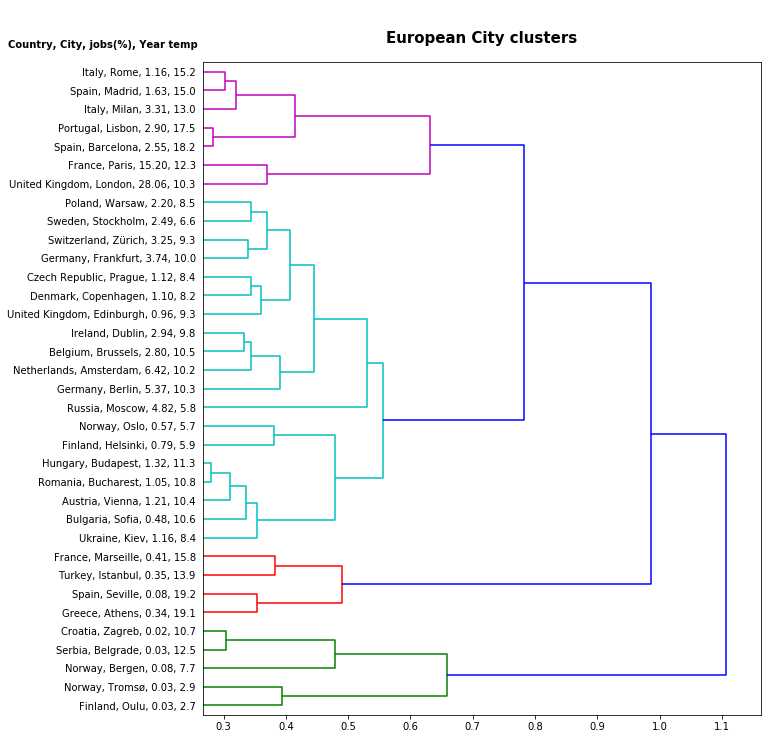

In [4]:
cdx = ctjf_wmink(ctjf_data2,tw=1,jw=1,fw=1)
#ctjf_dendro(cdx,'')
# labels = ttable.City.values
df = assembled_data
labels = ['{}, {}, {:.2f}, {}'.\
          format(df.Country[i],df.City[i],df.job_index[i]*100,df.Year[i]) for i in range(len(df.City.values))]
# hierarchical cluster
ccdx = hierarchy.complete(squareform(cdx)) # squareform is its own inverse, condenses and expands depending on the shape
plt.figure(figsize=(10,12))
R = hierarchy.dendrogram(ccdx,labels=labels,orientation='right',leaf_font_size=10)

mask = np.ones(cdx.shape, dtype=bool)
np.fill_diagonal(mask, 0)
plt.xlim(cdx[mask].min()*.95,cdx[mask].max()*1.05)
plt.title('European City clusters',fontdict={'fontsize': 15,'fontweight':'bold','verticalalignment':'baseline'},pad=20 )
plt.annotate('Country, City, jobs(%), Year temp',xy=(0.01,0.935),xycoords='figure fraction',\
             fontweight='bold')
plt.show()